In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import networkx as nx
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Import our modules
from sir_model import LinguisticContagionModel, SIRParameters, compare_scenarios
#from data_preprocessing import DataPreprocessor      empty??
from network import NetworkLCM

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
%matplotlib inline

print("=" * 70)
print("VIRAL LINGUISTICS: PREDICTING LANGUAGE CONTAGION PATTERNS")
print("Group 21 - Hy Le, Paris Tran, Reese Jednorozec, Namit Agrawal")
print("=" * 70)
print("\n✓ Environment configured successfully\n")

VIRAL LINGUISTICS: PREDICTING LANGUAGE CONTAGION PATTERNS
Group 21 - Hy Le, Paris Tran, Reese Jednorozec, Namit Agrawal

✓ Environment configured successfully



MOTIVATION:
   Language evolution in the digital age occurs at unprecedented speeds.
   New terms emerge daily across social media platforms, but we lack 
   predictive models to determine which innovations will "go viral."

RESEARCH QUESTIONS:
   1. Can we predict which linguistic innovations will spread virally?
   2. How do terms spread across different communities?
   3. What are the transmission dynamics of language contagion?
   4. When will a term reach peak usage?

OUR APPROACH:
   We adapt the SIR (Susceptible-Infected-Recovered) epidemiological
   model to linguistic data, treating language spread as a contagion
   phenomenon with predictable transmission patterns.

KEY INNOVATION:
   Unlike frequency-based trend analysis, our model:
   • Predicts FUTURE viral potential (not just historical trends)
   • Calculates R₀ to quantify spread likelihood
   • Models transmission dynamics across user populations
   • Provides mechanistic understanding of language spread

# 2 METHODOLOGY: LINGUISTIC CONTAGION MODEL (LCM)


2. METHODOLOGY: LINGUISTIC CONTAGION MODEL (LCM)

🧬 SIR FRAMEWORK:
   We divide the user population into three compartments:
   
   S (Susceptible) - Users who haven't adopted the term yet
   I (Infected)    - Users actively using the term
   R (Recovered)   - Users who stopped using the term

📐 MATHEMATICAL MODEL (from our proposal):

   Equation 1:  dS/dt = -βSI - μS + γR
   Equation 2:  dI/dt = βSI - αI - νI
   Equation 3:  dR/dt = αI - γR

🔧 PARAMETERS:
   β (beta)  - Transmission rate (how quickly term spreads)
   α (alpha) - Recovery rate (how fast users stop using it)
   ν (nu)    - Mutation rate (semantic change)
   μ (mu)    - Birth rate (new users joining platform)
   γ (gamma) - Re-susceptibility rate (users becoming susceptible again)

📏 KEY METRIC:
   R₀ = β / (α + ν)  [Basic Reproduction Number]
   
   If R₀ > 1 → Term will GO VIRAL ✓
   If R₀ < 1 → Term will DIE OUT ✗


🔬 DEMONSTRATING SIR DYNAMICS:
----------------------------------------------------------------------


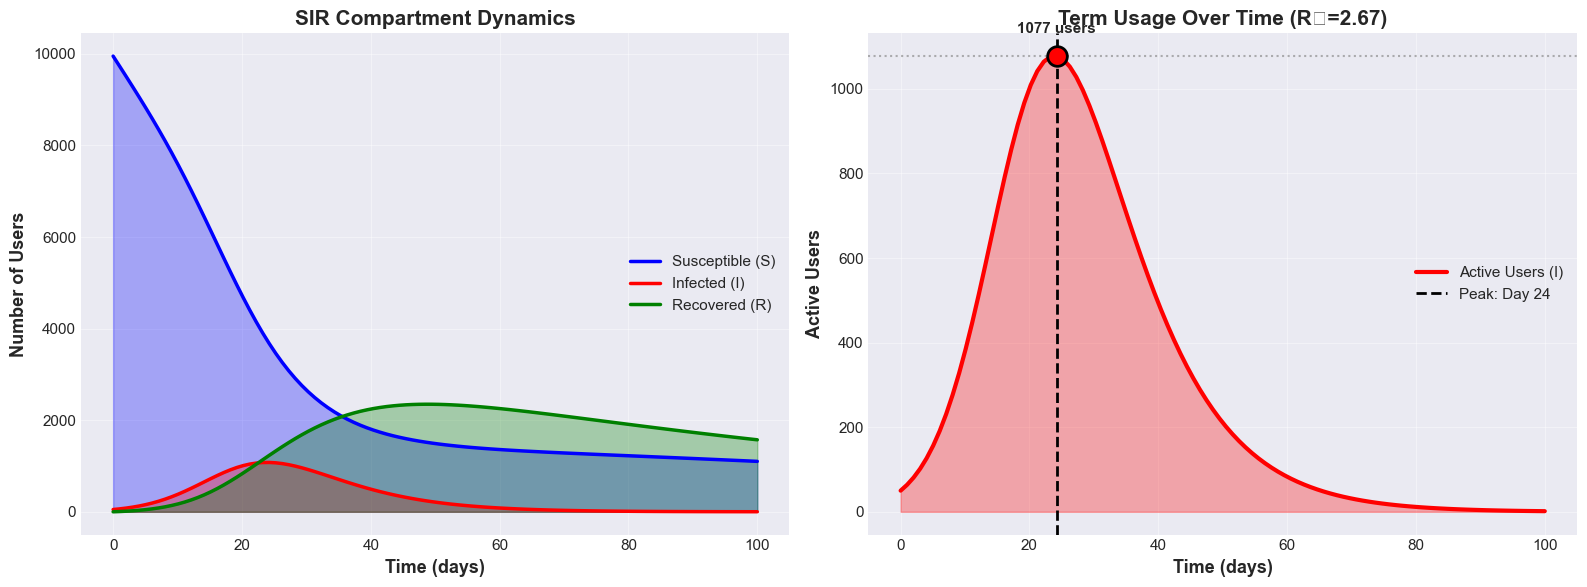


✓ Peak usage occurs at Day 24 with 1077 active users


In [ ]:


print("""
🧬 SIR FRAMEWORK:
   We divide the user population into three compartments:
   
   S (Susceptible) - Users who haven't adopted the term yet
   I (Infected)    - Users actively using the term
   R (Recovered)   - Users who stopped using the term

📐 MATHEMATICAL MODEL (from our proposal):

   Equation 1:  dS/dt = -βSI - μS + γR
   Equation 2:  dI/dt = βSI - αI - νI
   Equation 3:  dR/dt = αI - γR

🔧 PARAMETERS:
   β (beta)  - Transmission rate (how quickly term spreads)
   α (alpha) - Recovery rate (how fast users stop using it)
   ν (nu)    - Mutation rate (semantic change)
   μ (mu)    - Birth rate (new users joining platform)
   γ (gamma) - Re-susceptibility rate (users becoming susceptible again)

📏 KEY METRIC:
   R₀ = β / (α + ν)  [Basic Reproduction Number]
   
   If R₀ > 1 → Term will GO VIRAL ✓
   If R₀ < 1 → Term will DIE OUT ✗
""")

# Demonstrate SIR equations with a simple example
print("\n🔬 DEMONSTRATING SIR DYNAMICS:")
print("-" * 70)

# Create simple example
example_model = LinguisticContagionModel(
    SIRParameters(beta=0.4, alpha=0.1, nu=0.05, mu=0.02, gamma=0.01)
)

N_example = 10000  # Population
I0_example = 50    # Initial users

history = example_model.simulate(I0=I0_example, N=N_example, t_max=100)
R0 = example_model.calculate_R0()

print(f"\nExample Scenario:")
print(f"  • Population: {N_example:,} users")
print(f"  • Initial adopters: {I0_example}")
print(f"  • Transmission rate (β): {example_model.params.beta}")
print(f"  • Recovery rate (α): {example_model.params.alpha}")
print(f"  • R₀: {R0:.2f}")
print(f"  • Prediction: {'VIRAL (will spread)' if R0 > 1 else 'Will not spread'}")

# Plot example dynamics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: All compartments
ax1.plot(history['t'], history['S'], 'b-', linewidth=2.5, label='Susceptible (S)')
ax1.plot(history['t'], history['I'], 'r-', linewidth=2.5, label='Infected (I)')
ax1.plot(history['t'], history['R'], 'g-', linewidth=2.5, label='Recovered (R)')
ax1.fill_between(history['t'], history['S'], alpha=0.3, color='blue')
ax1.fill_between(history['t'], history['I'], alpha=0.3, color='red')
ax1.fill_between(history['t'], history['R'], alpha=0.3, color='green')
ax1.set_xlabel('Time (days)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Number of Users', fontsize=13, fontweight='bold')
ax1.set_title('SIR Compartment Dynamics', fontsize=15, fontweight='bold')
ax1.legend(fontsize=11, loc='right')
ax1.grid(True, alpha=0.4)

# Right: Focus on infected
peak_idx = history['I'].idxmax()
peak_time = history.loc[peak_idx, 't']
peak_val = history.loc[peak_idx, 'I']

ax2.plot(history['t'], history['I'], 'r-', linewidth=3, label='Active Users (I)')
ax2.axvline(peak_time, color='black', linestyle='--', linewidth=2, 
            label=f'Peak: Day {peak_time:.0f}')
ax2.axhline(peak_val, color='gray', linestyle=':', alpha=0.6)
ax2.scatter([peak_time], [peak_val], color='red', s=200, zorder=5, 
            edgecolors='black', linewidths=2)
ax2.fill_between(history['t'], history['I'], alpha=0.3, color='red')
ax2.set_xlabel('Time (days)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Active Users', fontsize=13, fontweight='bold')
ax2.set_title(f'Term Usage Over Time (R₀={R0:.2f})', fontsize=15, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.4)
ax2.text(peak_time, peak_val*1.05, f'{peak_val:.0f} users', 
         ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Peak usage occurs at Day {peak_time:.0f} with {peak_val:.0f} active users")

# 3. Data Preprocessing for Reddit/Twitter

In [6]:
DATA_FILE = 'reddit_data.csv'  
PLATFORM = 'reddit'            

print(f"\n📂 Configuration:")
print(f"   • Data file: {DATA_FILE}")
print(f"   • Platform: {PLATFORM}")
print(f"   • Min term length: {preprocessor.min_term_length}")
print(f"   • Min frequency: {preprocessor.min_frequency}")

# Try to load data
try:
    print(f"\n🔄 Loading data from {DATA_FILE}...")
    df = preprocessor.load_csv(DATA_FILE, platform=PLATFORM)
    
    summary = preprocessor.get_summary()
    
    print(f"\n✓ Data loaded successfully!")
    print(f"\n📊 DATASET SUMMARY:")
    print(f"   • Total posts: {summary['total_posts']:,}")
    print(f"   • Date range: {summary['date_range']['start'].date()} to {summary['date_range']['end'].date()}")
    print(f"   • Duration: {summary['date_range']['days']} days")
    if 'unique_users' in summary:
        print(f"   • Unique users: {summary['unique_users']:,}")
    if 'unique_communities' in summary:
        print(f"   • Communities: {summary['unique_communities']:,}")
    print(f"   • Avg text length: {summary['avg_text_length']:.1f} characters")
    
    # Show sample
    print(f"\n📝 SAMPLE POSTS:")
    print("-" * 70)
    sample_df = df[['timestamp', 'text']].head(3)
    for idx, row in sample_df.iterrows():
        print(f"\n[{row['timestamp']}]")
        print(f"{row['text'][:150]}..." if len(row['text']) > 150 else row['text'])
    
    DATA_LOADED = True
    
except FileNotFoundError:
    print(f"\n⚠️  WARNING: Data file not found: {DATA_FILE}")
    print("\n💡 TO USE YOUR OWN DATA:")
    print("   1. Update DATA_FILE variable above with your CSV path")
    print("   2. Ensure CSV has 'text' and 'timestamp' columns")
    print("   3. Re-run this cell")
    print("\n📖 For now, we'll use synthetic data for demonstration...")
    
    DATA_LOADED = False
    
    # Create synthetic data for demonstration
    np.random.seed(42)
    dates = pd.date_range('2023-01-01', periods=100, freq='D')
    synthetic_counts = np.random.poisson(lam=20, size=100)
    synthetic_counts[30:60] = synthetic_counts[30:60] * 3  # Create a peak
    
    time_series = pd.Series(synthetic_counts, index=dates)
    SELECTED_TERM = "example_term"
    N = 50000
    
    print("✓ Using synthetic data for demonstration")


📂 Configuration:
   • Data file: reddit_data.csv
   • Platform: reddit


NameError: name 'preprocessor' is not defined

# 4. TERM DETECTION


In [ ]:
# Term Detection Code 

# 5. SIR MODEL FITTING


In [ ]:
print(f"\n🔄 Fitting SIR model to '{SELECTED_TERM}' data...")

# Initialize and fit model
model = LinguisticContagionModel()

try:
    fitted_params = model.fit_to_data(time_series, population=N)
    
    print("\n✓ Model fitting completed successfully!")
    
    print(f"\n⚙️  FITTED PARAMETERS:")
    print("-" * 70)
    print(f"{'Parameter':<25} {'Value':<12} {'Interpretation'}")
    print("-" * 70)
    print(f"{'β (Transmission Rate)':<25} {fitted_params.beta:<12.4f} How fast term spreads")
    print(f"{'α (Recovery Rate)':<25} {fitted_params.alpha:<12.4f} How fast users stop using it")
    print(f"{'ν (Mutation Rate)':<25} {fitted_params.nu:<12.4f} Semantic drift rate")
    print(f"{'μ (Birth Rate)':<25} {fitted_params.mu:<12.4f} New user influx")
    print(f"{'γ (Re-susceptibility)':<25} {fitted_params.gamma:<12.4f} Users become susceptible again")
    
    R0 = model.calculate_R0()
    print("\n" + "=" * 70)
    print(f"🔬 R₀ (BASIC REPRODUCTION NUMBER): {R0:.3f}")
    print("=" * 70)
    
    if R0 > 1:
        print(f"✓ VIRAL PREDICTION: This term WILL SPREAD (R₀ = {R0:.2f} > 1)")
        print(f"  Each user will, on average, transmit the term to {R0:.2f} others")
    else:
        print(f"✗ NON-VIRAL: This term will NOT spread significantly (R₀ = {R0:.2f} < 1)")
    
    FITTING_SUCCESS = True
    
except Exception as e:
    print(f"\n⚠️  Fitting failed: {e}")
    print("Using default parameters for demonstration...")
    fitted_params = SIRParameters(beta=0.3, alpha=0.1, nu=0.05, mu=0.02, gamma=0.01)
    model.params = fitted_params
    FITTING_SUCCESS = False

NameError: name 'SELECTED_TERM' is not defined

# 6. MODEL SIMULATION AND RESULTS

VIRAL LINGUISTICS: COMPARING NETWORK EFFECTS ON LANGUAGE CONTAGION

1. Running standard SIR model (no network effects)...
  Standard SIR Results:
  - R₀: 2.00
  - Peak Time: Day 26.3
  - Peak Users: 65
  - Total Reached: 6.5%

2. Running network SIR model for Twitter...
  Twitter Network Results:
  - R₀: 2.00
  - Peak Time: Day 4.0
  - Peak Users: 998
  - Total Reached: 65.8%

3. Running network SIR model for Reddit...
  Reddit Network Results:
  - R₀: 2.00
  - Peak Time: Day 3.0
  - Peak Users: 1689
  - Total Reached: 91.8%


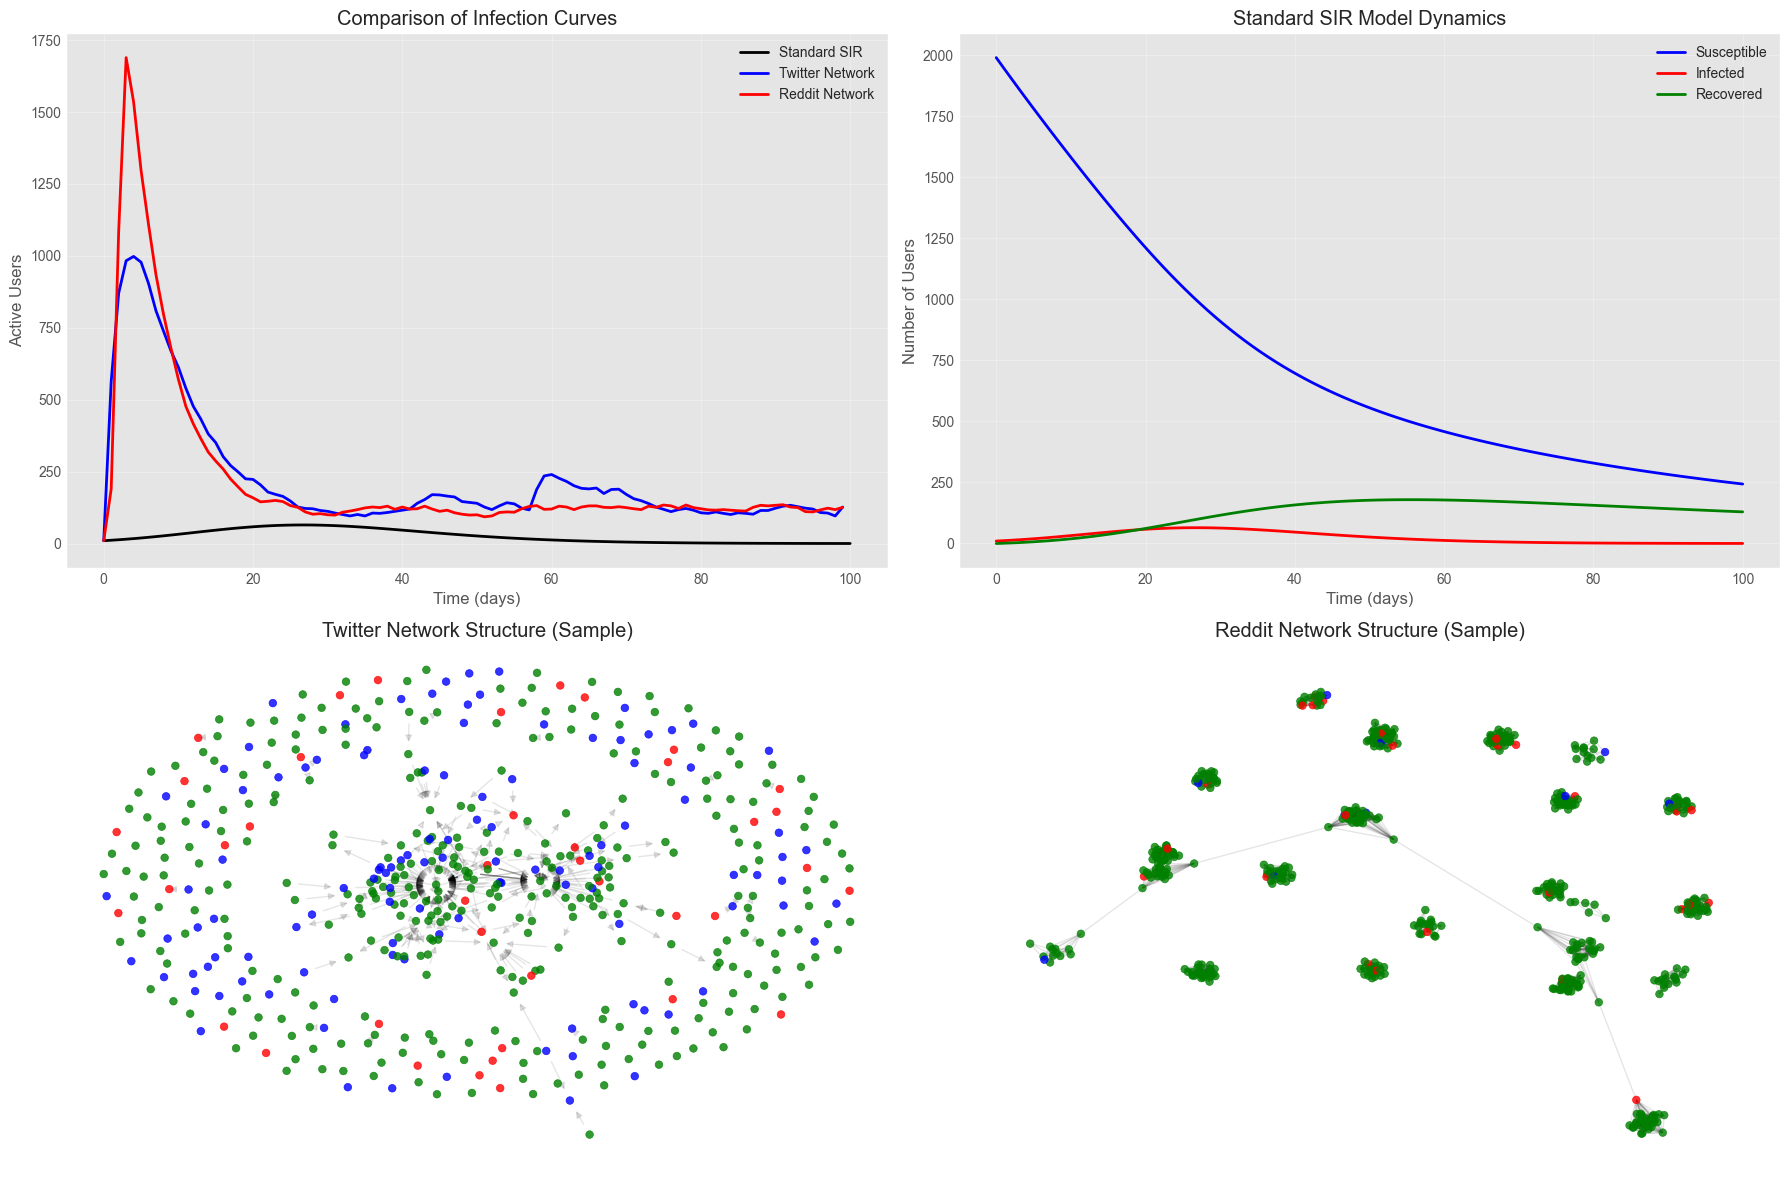

,R0,Peak Time,Peak Users,Total Reach %
Standard SIR,2.0,26.26,64.67,6.48
Twitter,2.0,4.00,998.00,65.80
Reddit,2.0,3.00,1689.00,91.80



4. Comparing different types of linguistic innovations...


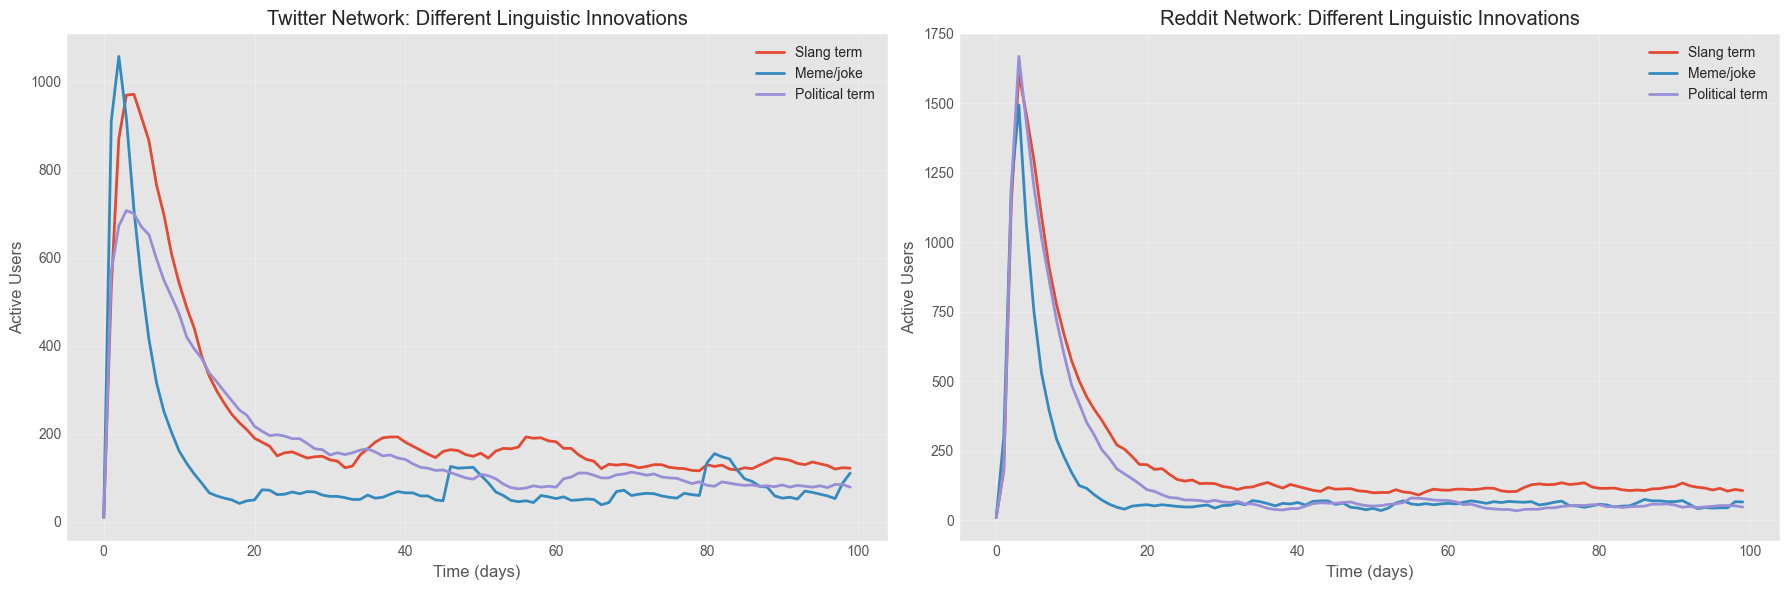


Twitter results for different linguistic innovations:


,R0,peak_time,peak_users,total_pct
Slang term,2.00,4.0,971.0,66.60
Meme/joke,1.67,2.0,1057.0,70.35
Political term,1.67,3.0,707.0,80.45



Reddit results for different linguistic innovations:


,R0,peak_time,peak_users,total_pct
Slang term,2.00,3.0,1607.0,92.95
Meme/joke,1.67,3.0,1494.0,93.15
Political term,1.67,3.0,1669.0,94.85


In [7]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['font.size'] = 12
plt.style.use('ggplot')

# Run the simulation
def run_comparison_simulation():
    """
    Compare standard SIR model with network models for Twitter and Reddit
    """
    print("=" * 80)
    print("VIRAL LINGUISTICS: COMPARING NETWORK EFFECTS ON LANGUAGE CONTAGION")
    print("=" * 80)
    
    # Simulation parameters
    N = 2000        # Network size
    I0 = 10         # Initial adopters
    t_max = 100     # Simulation duration
    
    # Initialize both models with the same parameters
    base_params = SIRParameters(
        beta=0.3,    # Transmission rate
        alpha=0.1,   # Recovery rate
        nu=0.05,     # Mutation rate
        mu=0.02,     # Birth rate
        gamma=0.01   # Re-susceptibility rate
    )
    
    # Create figure for comparison plots
    fig = plt.figure(figsize=(18, 12))
    
    # Standard SIR model
    print("\n1. Running standard SIR model (no network effects)...")
    std_model = LinguisticContagionModel(params=base_params)
    std_history = std_model.simulate(I0, N, t_max)
    std_stats = std_model.summary_statistics()
    
    print(f"  Standard SIR Results:")
    print(f"  - R₀: {std_stats['R0']:.2f}")
    print(f"  - Peak Time: Day {std_stats['peak_time']:.1f}")
    print(f"  - Peak Users: {std_stats['peak_infections']:.0f}")
    print(f"  - Total Reached: {std_stats['total_infected_pct']:.1f}%")
    
    # Network-aware SIR model for Twitter
    print("\n2. Running network SIR model for Twitter...")
    twitter_model = NetworkLCM(params=base_params)
    twitter_history = twitter_model.simulate_network_spread(I0, N, platform="twitter", t_max=t_max)
    twitter_stats = twitter_model.summary_statistics()
    
    print(f"  Twitter Network Results:")
    print(f"  - R₀: {twitter_stats['R0']:.2f}")
    print(f"  - Peak Time: Day {twitter_stats['peak_time']:.1f}")
    print(f"  - Peak Users: {twitter_stats['peak_infections']:.0f}")
    print(f"  - Total Reached: {twitter_stats['total_infected_pct']:.1f}%")
    
    # Network-aware SIR model for Reddit
    print("\n3. Running network SIR model for Reddit...")
    reddit_model = NetworkLCM(params=base_params)
    reddit_history = reddit_model.simulate_network_spread(I0, N, platform="reddit", t_max=t_max)
    reddit_stats = reddit_model.summary_statistics()
    
    print(f"  Reddit Network Results:")
    print(f"  - R₀: {reddit_stats['R0']:.2f}")
    print(f"  - Peak Time: Day {reddit_stats['peak_time']:.1f}")
    print(f"  - Peak Users: {reddit_stats['peak_infections']:.0f}")
    print(f"  - Total Reached: {reddit_stats['total_infected_pct']:.1f}%")
    
    # Plot 1: Infection Curves Comparison
    ax1 = fig.add_subplot(2, 2, 1)
    
    ax1.plot(std_history['t'], std_history['I'], 'k-', 
             label='Standard SIR', linewidth=2)
    ax1.plot(twitter_history['t'], twitter_history['I'], 'b-', 
             label='Twitter Network', linewidth=2)
    ax1.plot(reddit_history['t'], reddit_history['I'], 'r-', 
             label='Reddit Network', linewidth=2)
    
    ax1.set_xlabel('Time (days)')
    ax1.set_ylabel('Active Users')
    ax1.set_title('Comparison of Infection Curves')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: All Compartments for Standard SIR
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(std_history['t'], std_history['S'], 'b-', label='Susceptible', linewidth=2)
    ax2.plot(std_history['t'], std_history['I'], 'r-', label='Infected', linewidth=2)
    ax2.plot(std_history['t'], std_history['R'], 'g-', label='Recovered', linewidth=2)
    ax2.set_xlabel('Time (days)')
    ax2.set_ylabel('Number of Users')
    ax2.set_title('Standard SIR Model Dynamics')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Plot 3: Twitter Network Visualization
    ax3 = fig.add_subplot(2, 2, 3)
    
    # Create a smaller visualization network for display purposes
    viz_network = twitter_model.network
    if len(viz_network.nodes()) > 500:  # If network is large, sample it for visualization
        viz_network = nx.convert_node_labels_to_integers(
            nx.subgraph(twitter_model.network, np.random.choice(list(twitter_model.network.nodes()), 500, replace=False))
        )
        
    # Colormap for node states
    color_map = {"S": "blue", "I": "red", "R": "green"}
    node_colors = []
    for node in viz_network.nodes():
        if node in twitter_model.node_states:
            node_colors.append(color_map[twitter_model.node_states[node]])
        else:
            node_colors.append("gray")  # For nodes not in the original network
    
    # Draw network
    pos = nx.spring_layout(viz_network, seed=42)
    nx.draw_networkx_nodes(viz_network, pos, node_size=30, node_color=node_colors, alpha=0.8, ax=ax3)
    nx.draw_networkx_edges(viz_network, pos, alpha=0.1, ax=ax3)
    
    ax3.set_title('Twitter Network Structure (Sample)')
    ax3.axis('off')
    
    # Plot 4: Reddit Network Visualization
    ax4 = fig.add_subplot(2, 2, 4)
    
    # Create a smaller visualization network for display purposes
    viz_network = reddit_model.network
    if len(viz_network.nodes()) > 500:  # If network is large, sample it for visualization
        viz_network = nx.convert_node_labels_to_integers(
            nx.subgraph(reddit_model.network, np.random.choice(list(reddit_model.network.nodes()), 500, replace=False))
        )
    
    # Colormap for node states
    node_colors = []
    for node in viz_network.nodes():
        if node in reddit_model.node_states:
            node_colors.append(color_map[reddit_model.node_states[node]])
        else:
            node_colors.append("gray")  # For nodes not in the original network
    
    # Draw network
    pos = nx.spring_layout(viz_network, seed=42)
    nx.draw_networkx_nodes(viz_network, pos, node_size=30, node_color=node_colors, alpha=0.8, ax=ax4)
    nx.draw_networkx_edges(viz_network, pos, alpha=0.1, ax=ax4)
    
    ax4.set_title('Reddit Network Structure (Sample)')
    ax4.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Comparison table
    comparison_data = {
        "Standard SIR": {
            "R0": std_stats["R0"],
            "Peak Time": std_stats["peak_time"],
            "Peak Users": std_stats["peak_infections"],
            "Total Reach %": std_stats["total_infected_pct"]
        },
        "Twitter": {
            "R0": twitter_stats["R0"],
            "Peak Time": twitter_stats["peak_time"],
            "Peak Users": twitter_stats["peak_infections"],
            "Total Reach %": twitter_stats["total_infected_pct"]
        },
        "Reddit": {
            "R0": reddit_stats["R0"],
            "Peak Time": reddit_stats["peak_time"],
            "Peak Users": reddit_stats["peak_infections"],
            "Total Reach %": reddit_stats["total_infected_pct"]
        }
    }
    
    comparison_df = pd.DataFrame(comparison_data).T
    comparison_df = comparison_df.round(2)
    
    display(comparison_df)
    
    # Additional experiment: Different types of linguistic innovations
    print("\n4. Comparing different types of linguistic innovations...")
    
    scenarios = {
        "Slang term": SIRParameters(beta=0.3, alpha=0.1, nu=0.05, mu=0.02, gamma=0.01),
        "Meme/joke": SIRParameters(beta=0.5, alpha=0.2, nu=0.1, mu=0.02, gamma=0.01),  # Fast spread, fast decay
        "Political term": SIRParameters(beta=0.25, alpha=0.05, nu=0.1, mu=0.03, gamma=0.005)  # Polarizing, mutates more
    }
    
    # Set up figure for term comparison
    fig2, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Compare between Twitter and Reddit
    results = {}
    for platform_idx, platform in enumerate(["twitter", "reddit"]):
        plt_lines = []
        plt_labels = []
        
        platform_results = {}
        for name, params in scenarios.items():
            model = NetworkLCM(params=params)
            history = model.simulate_network_spread(I0, N, platform=platform, t_max=t_max)
            stats = model.summary_statistics()
            
            # Plot the infection curve
            line, = axes[platform_idx].plot(history['t'], history['I'], linewidth=2)
            plt_lines.append(line)
            plt_labels.append(name)
            
            # Store statistics
            platform_results[name] = {
                'R0': stats['R0'],
                'peak_time': stats['peak_time'],
                'peak_users': stats['peak_infections'],
                'total_pct': stats['total_infected_pct']
            }
        
        results[platform] = platform_results
        
        # Configure subplot
        axes[platform_idx].set_title(f'{platform.capitalize()} Network: Different Linguistic Innovations')
        axes[platform_idx].set_xlabel('Time (days)')
        axes[platform_idx].set_ylabel('Active Users')
        axes[platform_idx].grid(True, alpha=0.3)
        axes[platform_idx].legend(plt_lines, plt_labels)
    
    plt.tight_layout()
    plt.show()
    
    # Display result tables
    twitter_df = pd.DataFrame(results['twitter']).T
    reddit_df = pd.DataFrame(results['reddit']).T
    
    print("\nTwitter results for different linguistic innovations:")
    display(twitter_df.round(2))
    
    print("\nReddit results for different linguistic innovations:")
    display(reddit_df.round(2))
    
    return std_model, twitter_model, reddit_model, results

# Run the simulation
std_model, twitter_model, reddit_model, results = run_comparison_simulation()

# 7 MODEL EVALUATION 

In [ ]:
#code 